### Imports<a id='imports'>
   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn import metrics
import pmdarima as pm
from pmdarima import auto_arima 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from prophet import Prophet
# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
# Process bar
from tqdm import tqdm
# Tracking time
from time import time
import warnings
warnings.filterwarnings('ignore')

### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary_gp_apd_code = pd.read_csv('crimes_summary_gp_apd_code.csv', parse_dates=['occurred_date'])

In [3]:
df_crimes_summary_gp_apd_code.head()

,occurred_date,sector,ucr_code,count
0,2003-01-01,ADAM,1000,1
1,2003-01-01,ADAM,1199,1
2,2003-01-01,ADAM,1400,2
3,2003-01-01,ADAM,2100,2
4,2003-01-01,ADAM,2703,2


In [4]:
data2 = df_crimes_summary_gp_apd_code.loc[(df_crimes_summary_gp_apd_code['sector'].isin(['BAKER', 'FRANK', 'IDA', 'DAVID', 'ADAM', 'CHARLIE', 'HENRY',
       'GEORGE', 'EDWARD', 'APT']) ) & (df_crimes_summary_gp_apd_code['ucr_code'].isin([600,601])), ['occurred_date', 'sector', 'ucr_code', 'count']]

In [5]:
data2.shape

(119873, 4)

In [6]:
data2['occurred_date'] = pd.to_datetime(data2['occurred_date'])
data2['year'] = data2['occurred_date'].dt.year

In [7]:
data2.head()

,occurred_date,sector,ucr_code,count,year
12,2003-01-01,ADAM,600,4,2003
13,2003-01-01,ADAM,601,5,2003
31,2003-01-01,BAKER,600,3,2003
32,2003-01-01,BAKER,601,5,2003
52,2003-01-01,CHARLIE,600,4,2003


In [8]:
data2_2022 = data2[data2['year'] >= 2022]

In [9]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
916194,2022-01-01,ADAM,600,2,2022
916195,2022-01-01,ADAM,601,1,2022
916207,2022-01-01,BAKER,601,8,2022
916217,2022-01-01,CHARLIE,600,2,2022
916218,2022-01-01,CHARLIE,601,4,2022


In [10]:
data2_2022 = data2_2022.reset_index()

In [11]:
data2_2022.head()

,index,occurred_date,sector,ucr_code,count,year
0,916194,2022-01-01,ADAM,600,2,2022
1,916195,2022-01-01,ADAM,601,1,2022
2,916207,2022-01-01,BAKER,601,8,2022
3,916217,2022-01-01,CHARLIE,600,2,2022
4,916218,2022-01-01,CHARLIE,601,4,2022


In [12]:
data2_2022.drop('index',axis=1,inplace=True)

In [13]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
0,2022-01-01,ADAM,600,2,2022
1,2022-01-01,ADAM,601,1,2022
2,2022-01-01,BAKER,601,8,2022
3,2022-01-01,CHARLIE,600,2,2022
4,2022-01-01,CHARLIE,601,4,2022


In [14]:
data2_2022.shape

(6311, 5)

In [15]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                  int64
count                     int64
year                      int64
dtype: object

In [16]:
data2_2022['ucr_code'] = data2_2022['ucr_code'].astype(str)

In [17]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                 object
count                     int64
year                      int64
dtype: object

### Resampling the data<a id='resampling'>
    
* Upsampling is when the frequency of samples is increased (e.g. days to hours)
* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
I will do some downsampling with the .resample() function to reduce the noise.

<AxesSubplot:title={'center':'Resampled Weekly'}, xlabel='occurred_date', ylabel='count'>

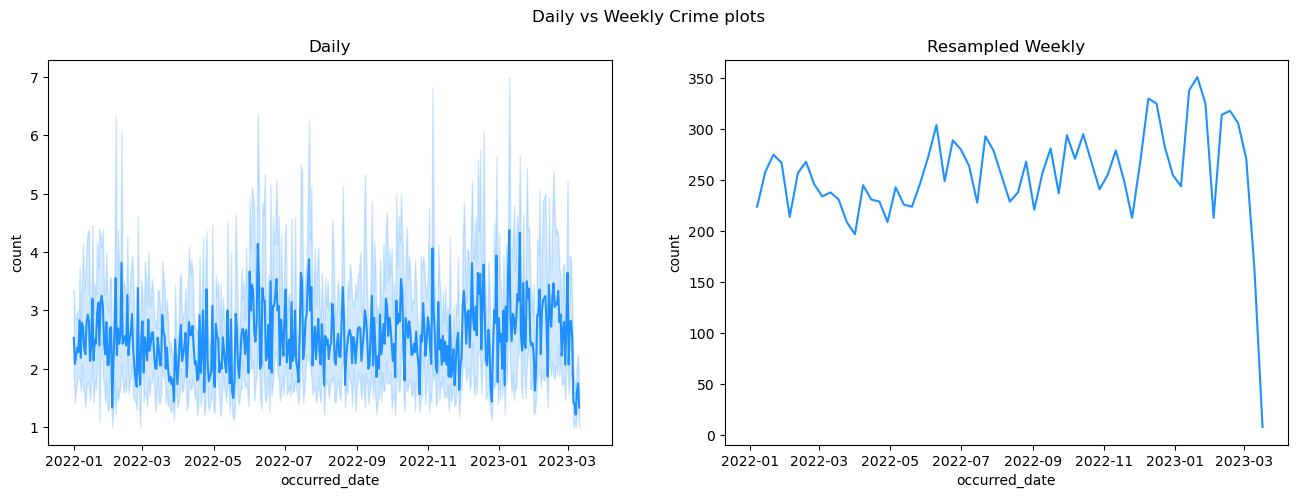

In [18]:
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(16, 5))
figure.suptitle('Daily vs Weekly Crime plots')
axes[0].set_title('Daily')
axes[1].set_title('Resampled Weekly')
sns.lineplot(x='occurred_date', y='count', data = data2_2022, color='dodgerblue', ax=axes[0])
resampled_df = data2_2022[['occurred_date','count']].resample('W-FRI', on='occurred_date').sum().reset_index(drop=False)
sns.lineplot(x='occurred_date', y='count',data=resampled_df, color='dodgerblue', ax=axes[1])


##### Downsampling the data using resample function

I had to use groupby based on categorical variables

In [19]:
weekly_data_adv =  data2_2022.groupby(['ucr_code','sector']).resample('W-FRI', label='right', closed = 'right', on='occurred_date').sum().reset_index().sort_values(by='occurred_date').reset_index()

In [20]:
weekly_data_adv.head()

,index,ucr_code,sector,occurred_date,count,year
0,0,600,ADAM,2022-01-07,13,10110
1,738,601,BAKER,2022-01-07,28,12132
2,1175,601,IDA,2022-01-07,11,8088
3,863,601,DAVID,2022-01-07,17,14154
4,62,600,APT,2022-01-07,1,2022


In [21]:
weekly_data_adv.drop('index',axis=1,inplace=True)

In [22]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count,year
0,600,ADAM,2022-01-07,13,10110
1,601,BAKER,2022-01-07,28,12132
2,601,IDA,2022-01-07,11,8088
3,601,DAVID,2022-01-07,17,14154
4,600,APT,2022-01-07,1,2022


In [23]:
weekly_data_adv.year.unique()

array([10110, 12132,  8088, 14154,  2022,  6066,  4044,     0, 10114,
        8091, 14160, 12137,  8092,  2023, 10115, 12138, 14161,  6069,
        4046], dtype=int64)

In [24]:
weekly_data_adv.drop('year',axis=1,inplace=True)

In [25]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count
0,600,ADAM,2022-01-07,13
1,601,BAKER,2022-01-07,28
2,601,IDA,2022-01-07,11
3,601,DAVID,2022-01-07,17
4,600,APT,2022-01-07,1


In [26]:
weekly_data_adv[weekly_data_adv['count'] == 0]

,ucr_code,sector,occurred_date,count
139,600,APT,2022-02-25,0
149,601,APT,2022-02-25,0
157,601,APT,2022-03-04,0
191,601,APT,2022-03-11,0
202,601,APT,2022-03-18,0
221,601,APT,2022-03-25,0
257,601,APT,2022-04-08,0
283,600,APT,2022-04-15,0
292,601,APT,2022-04-15,0
340,601,APT,2022-05-06,0


In [27]:
#saving this weekly data  file
csv_name = "wkly_crimes_per_sector_ucr.csv"
weekly_data_adv.to_csv(csv_name, index=False)

In [28]:
weekly_data = pd.read_csv('wkly_crimes_per_sector_ucr.csv', parse_dates=['occurred_date'])

In [29]:
weekly_data.shape

(1237, 4)

In [30]:
# combine sector and ucr_code column as time_series
weekly_data['sector'] = ['sec_' + str(i) for i in weekly_data['sector']]
weekly_data['ucr_code'] = ['code_' + str(i) for i in weekly_data['ucr_code']]
weekly_data['time_series'] = weekly_data[['sector', 'ucr_code']].apply(lambda x: '_'.join(x), axis=1)

In [31]:
weekly_data = weekly_data.rename(columns={'occurred_date': 'ds', 'count': 'y'})

In [32]:
weekly_data.head()

,ucr_code,sector,ds,y,time_series
0,code_600,sec_ADAM,2022-01-07,13,sec_ADAM_code_600
1,code_601,sec_BAKER,2022-01-07,28,sec_BAKER_code_601
2,code_601,sec_IDA,2022-01-07,11,sec_IDA_code_601
3,code_601,sec_DAVID,2022-01-07,17,sec_DAVID_code_601
4,code_600,sec_APT,2022-01-07,1,sec_APT_code_600


## PIVOT the data<a id='pivot'>

In [33]:
pivoted_df = weekly_data.pivot(index='ds', columns='time_series', values='y')

print(pivoted_df.head())

time_series  sec_ADAM_code_600  sec_ADAM_code_601  sec_APT_code_600  \
ds                                                                    
2022-01-07                13.0               18.0               1.0   
2022-01-14                 7.0               22.0               2.0   
2022-01-21                11.0               25.0               6.0   
2022-01-28                11.0               12.0               1.0   
2022-02-04                 5.0               23.0               3.0   

time_series  sec_APT_code_601  sec_BAKER_code_600  sec_BAKER_code_601  \
ds                                                                      
2022-01-07                NaN                 8.0                28.0   
2022-01-14                NaN                 5.0                59.0   
2022-01-21                NaN                12.0                34.0   
2022-01-28                NaN                14.0                41.0   
2022-02-04                NaN                 6.0               

Filling up NaN values with zero

In [34]:
pivoted_df.replace(np.NaN, 0, inplace=True)

In [35]:
pivoted_df

time_series,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,sec_DAVID_code_601,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
ds,,,,,,,,,,,,,,,,,,,,
2022-01-07,13.0,18.0,1.0,0.0,8.0,28.0,7.0,17.0,13.0,17.0,12.0,8.0,9.0,15.0,5.0,4.0,6.0,23.0,9.0,11.0
2022-01-14,7.0,22.0,2.0,0.0,5.0,59.0,4.0,12.0,8.0,23.0,7.0,17.0,9.0,14.0,10.0,8.0,7.0,19.0,10.0,15.0
2022-01-21,11.0,25.0,6.0,0.0,12.0,34.0,11.0,8.0,9.0,29.0,13.0,16.0,14.0,24.0,9.0,13.0,3.0,22.0,8.0,8.0
2022-01-28,11.0,12.0,1.0,0.0,14.0,41.0,8.0,11.0,3.0,36.0,8.0,22.0,10.0,20.0,8.0,9.0,5.0,18.0,10.0,20.0
2022-02-04,5.0,23.0,3.0,0.0,6.0,28.0,7.0,8.0,10.0,16.0,11.0,8.0,4.0,13.0,11.0,4.0,11.0,25.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17,17.0,34.0,1.0,1.0,12.0,40.0,11.0,10.0,12.0,54.0,11.0,13.0,11.0,30.0,9.0,7.0,11.0,10.0,9.0,15.0
2023-02-24,12.0,33.0,2.0,0.0,13.0,43.0,13.0,10.0,25.0,40.0,11.0,13.0,13.0,18.0,9.0,6.0,12.0,6.0,6.0,21.0
2023-03-03,10.0,42.0,1.0,0.0,10.0,27.0,8.0,10.0,10.0,39.0,11.0,20.0,11.0,16.0,7.0,3.0,9.0,22.0,5.0,10.0


In [36]:
pivoted_df.shape

(63, 20)

In [37]:
pivoted_df.reset_index(inplace=True)

In [38]:
pivoted_df.head()

time_series,ds,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,...,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
0,2022-01-07,13.0,18.0,1.0,0.0,8.0,28.0,7.0,17.0,13.0,...,12.0,8.0,9.0,15.0,5.0,4.0,6.0,23.0,9.0,11.0
1,2022-01-14,7.0,22.0,2.0,0.0,5.0,59.0,4.0,12.0,8.0,...,7.0,17.0,9.0,14.0,10.0,8.0,7.0,19.0,10.0,15.0
2,2022-01-21,11.0,25.0,6.0,0.0,12.0,34.0,11.0,8.0,9.0,...,13.0,16.0,14.0,24.0,9.0,13.0,3.0,22.0,8.0,8.0
3,2022-01-28,11.0,12.0,1.0,0.0,14.0,41.0,8.0,11.0,3.0,...,8.0,22.0,10.0,20.0,8.0,9.0,5.0,18.0,10.0,20.0
4,2022-02-04,5.0,23.0,3.0,0.0,6.0,28.0,7.0,8.0,10.0,...,11.0,8.0,4.0,13.0,11.0,4.0,11.0,25.0,10.0,11.0


In [39]:
pivoted_df.tail()

time_series,ds,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,...,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
58,2023-02-17,17.0,34.0,1.0,1.0,12.0,40.0,11.0,10.0,12.0,...,11.0,13.0,11.0,30.0,9.0,7.0,11.0,10.0,9.0,15.0
59,2023-02-24,12.0,33.0,2.0,0.0,13.0,43.0,13.0,10.0,25.0,...,11.0,13.0,13.0,18.0,9.0,6.0,12.0,6.0,6.0,21.0
60,2023-03-03,10.0,42.0,1.0,0.0,10.0,27.0,8.0,10.0,10.0,...,11.0,20.0,11.0,16.0,7.0,3.0,9.0,22.0,5.0,10.0
61,2023-03-10,8.0,17.0,6.0,0.0,9.0,18.0,3.0,7.0,7.0,...,12.0,10.0,6.0,10.0,5.0,5.0,5.0,10.0,2.0,6.0
62,2023-03-17,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


## Split Data<a id='split_data'>

In [40]:
train_w = pivoted_df[pivoted_df['ds'] <= '2022-12-30'].copy()
test_w = pivoted_df[pivoted_df['ds'] > '2022-12-30'].copy()

In [41]:
train_w.shape, test_w.shape

((52, 21), (11, 21))

In [42]:
train_w.set_index('ds', inplace=True)

In [43]:
test_w.set_index('ds', inplace=True)

## PMDARIMA - AUTO_ARIMA<a id='auto_arima'>

In [44]:
import pmdarima as pmd

In [45]:
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    ##r2_square = metrics.r2_score(true, predicted)
   # ybar = np.sum(true) / len(true) #yes, we could use np.mean(y)
    #sum_sq_tot = np.sum((true - ybar)**2) #total sum of squares error
    #sum_sq_res = np.sum((true - predicted)**2) #residual sum of squares error
   # r2_square = 1.0 - sum_sq_res / sum_sq_tot
    ###
    ape = np.abs((true - predicted)/true)
    ape[~np.isfinite(ape)] = 1
    mape=round((np.mean(ape) *100),2)
    ### to calculate WMAPE, weighted MAPE, we need to first calculate weighter error. sum(weighter error) /sum(actual)
    #weighted error is calculated as: |actual-forecast| / |actual| * 100 * actual
    wmape=round((np.sum(abs(true-predicted))/np.sum(true)) * 100,2)
    return mae, mse, rmse, mape, wmape

In [46]:
def arimamodel(timeseriesarray):
    #future_forecast = pd.DataFrame()
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                            d=2, # maximum order of differencing
                            max_p=5,  # maximum order of AR terms
                            max_q=5,  # maximum order of MA terms
                            seasonal=False,  # non-seasonal data
                            suppress_warnings=True  # suppress convergence warnings
                            )
    return autoarima_model

In [47]:
%%time
# Start time
start_time = time()
# Fit the model for each time series
eval_results_df = pd.DataFrame()
for col in train_w.columns:
        arima_model = arimamodel(train_w[col])
        arima_model.summary()
        # Fit the model
        arima_model.fit(train_w[col])

        # Make predictions on the testing set
        preds = arima_model.predict(len(test_w))
        #print("preds: ",preds)
        #print("test :",test_w[col])
        #print("col :",col)
        # Calculate the mean absolute error
        #mae = mean_absolute_error(test_w[col], preds)

        #print(f'{col}: MAE = {mae:.2f}')
        
        # Model Evaluation
        results_df_2 = pd.DataFrame(data=[[col,  *evaluate(test_w[col], preds)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
        eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        
        print('The time used for the for-loop forecast is ', time()-start_time)
        #print("eval results: ",eval_results_df) 

The time used for the for-loop forecast is  0.6574511528015137
The time used for the for-loop forecast is  1.3356189727783203
The time used for the for-loop forecast is  1.9932138919830322
The time used for the for-loop forecast is  3.4042365550994873
The time used for the for-loop forecast is  3.9031898975372314
The time used for the for-loop forecast is  4.85425329208374
The time used for the for-loop forecast is  5.4023425579071045
The time used for the for-loop forecast is  6.226500988006592
The time used for the for-loop forecast is  6.712611436843872
The time used for the for-loop forecast is  7.3485822677612305
The time used for the for-loop forecast is  8.020124673843384
The time used for the for-loop forecast is  8.627641677856445
The time used for the for-loop forecast is  9.517656564712524
The time used for the for-loop forecast is  10.112455129623413
The time used for the for-loop forecast is  10.91355276107788
The time used for the for-loop forecast is  11.847103357315063


In [48]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,5.255987,35.240957,5.936409,50.55,46.63
1,sec_ADAM_code_601,30.622345,1310.440403,36.200006,104.21,106.26
2,sec_APT_code_600,1.716303,3.815042,1.953213,79.01,82.08
3,sec_APT_code_601,1.438198,2.479228,1.574556,86.39,395.50
4,sec_BAKER_code_600,32.184972,1195.643741,34.578082,305.93,350.53
5,sec_BAKER_code_601,11.213140,210.924855,14.523252,182.78,34.94
6,sec_CHARLIE_code_600,3.589154,16.417885,4.051899,97.21,47.00
7,sec_CHARLIE_code_601,3.506373,20.202983,4.494773,31.32,33.83
8,sec_DAVID_code_600,20.246118,515.441883,22.703345,276.60,178.17
9,sec_DAVID_code_601,40.168878,1953.306671,44.196229,106.15,109.10


In [49]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,10.606761,301.317058,12.398493,109.310000,98.603500
std,11.245598,542.635510,12.464452,74.821689,100.773774
min,1.438198,2.479228,1.574556,31.320000,33.830000
25%,3.634523,20.203876,4.494872,61.037500,44.697500
50%,5.565193,50.355324,7.095274,85.865000,61.710000
75%,11.723228,240.235206,15.421279,141.005000,106.970000
max,40.168878,1953.306671,44.196229,305.930000,395.500000


In [50]:
eval_results_df.set_index('Time Series',inplace=True)

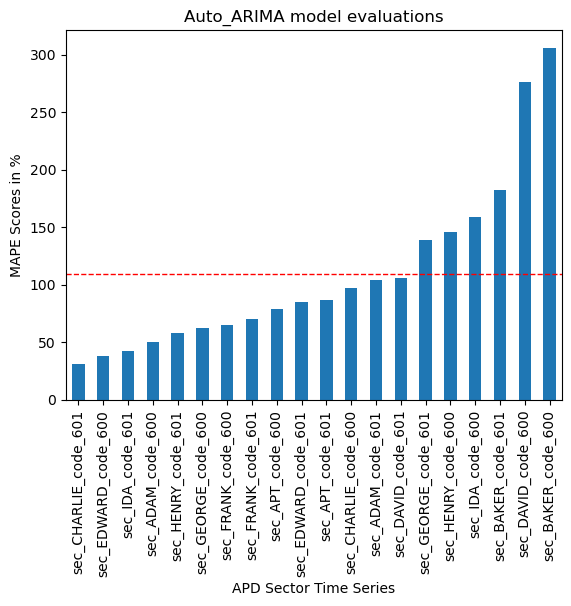

In [51]:
df_sorted = eval_results_df.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Auto_ARIMA model evaluations")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')

## PROPHET

In [52]:
pivoted_df.set_index('ds',inplace=True)

In [53]:
prophet_df = pivoted_df

In [54]:
prophet_df.columns

Index(['sec_ADAM_code_600', 'sec_ADAM_code_601', 'sec_APT_code_600',
       'sec_APT_code_601', 'sec_BAKER_code_600', 'sec_BAKER_code_601',
       'sec_CHARLIE_code_600', 'sec_CHARLIE_code_601', 'sec_DAVID_code_600',
       'sec_DAVID_code_601', 'sec_EDWARD_code_600', 'sec_EDWARD_code_601',
       'sec_FRANK_code_600', 'sec_FRANK_code_601', 'sec_GEORGE_code_600',
       'sec_GEORGE_code_601', 'sec_HENRY_code_600', 'sec_HENRY_code_601',
       'sec_IDA_code_600', 'sec_IDA_code_601'],
      dtype='object', name='time_series')

In [55]:
# Reshape data into a suitable format for Prophet
df = prophet_df.stack().reset_index()


In [56]:
df.columns = ['ds', 'series', 'y']

In [57]:
df.head()

,ds,series,y
0,2022-01-07,sec_ADAM_code_600,13.0
1,2022-01-07,sec_ADAM_code_601,18.0
2,2022-01-07,sec_APT_code_600,1.0
3,2022-01-07,sec_APT_code_601,0.0
4,2022-01-07,sec_BAKER_code_600,8.0


In [58]:
df.shape

(1260, 3)

In [59]:
def train_and_forecast(data_ts):
    # Instantiate the Prophet model
      model = Prophet()
  
      # Fit the model
      model.fit(data_ts)
      # Make predictions
      future = model.make_future_dataframe(periods=14)
      forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
      #forecast['sector'] = data_ts['time_series'].iloc[0]
      forecast['y'] = data_ts['y'].iloc[0]
      # Return the forecasted results
      return forecast[['ds','y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [64]:
%%time
# Start time
start_time = time()
eval_results_df = pd.DataFrame()
# Fit the model for each time series
for series_name in prophet_df.columns:
    ts_code = series_name
    # Filter the DataFrame to include only the data for this series
    series_data = df[df['series'] == series_name][['ds', 'y']]
    series_data.columns = ['ds', 'y']
    forecast = train_and_forecast(series_data)
     
    # Plot the forecast
    #fig = model.plot(forecast)
    #fig.suptitle(series_name)
    y_true = forecast['y'].values
    y_pred = forecast['yhat'].values
    # Model Evaluation
    results_df_2 = pd.DataFrame(data=[[ts_code, *evaluate(y_true,y_pred)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
    eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        
    print('The time used for the for-loop forecast is ', time()-start_time)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  1.4306175708770752


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  3.273500680923462


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  5.653223037719727


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  6.953364133834839


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  8.658951997756958


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  10.651630401611328


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  12.52226209640503


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  15.571762084960938


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  17.381945371627808


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  19.573185205459595


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  22.5989727973938


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  23.33228349685669


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  25.586193084716797


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  28.053062677383423


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  29.773407697677612


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  30.614418029785156


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  31.315097093582153


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  32.03519558906555


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  33.05022382736206
The time used for the for-loop forecast is  33.89898109436035
Wall time: 33.9 s


In [65]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,1.620902,2.875501,1.695730,12.47,12.47
1,sec_ADAM_code_601,8.729900,87.185518,9.337319,48.50,48.50
2,sec_APT_code_600,1.553005,2.514308,1.585657,155.30,155.30
3,sec_APT_code_601,0.457586,0.255316,0.505288,100.00,inf
4,sec_BAKER_code_600,1.637821,2.695858,1.641907,20.47,20.47
5,sec_BAKER_code_601,5.838103,34.176730,5.846087,20.85,20.85
6,sec_CHARLIE_code_600,1.651213,2.753963,1.659507,23.59,23.59
7,sec_CHARLIE_code_601,6.979707,48.753564,6.982375,41.06,41.06
8,sec_DAVID_code_600,1.442526,2.740163,1.655344,11.10,11.10
9,sec_DAVID_code_601,16.625871,290.329198,17.039049,97.80,97.80


In [66]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.000000,20.0000
mean,3.871626,31.963002,3.983974,43.254500,inf
std,4.036168,66.877332,4.115561,38.220073,NaN
min,0.457586,0.255316,0.505288,7.670000,7.6700
25%,1.542606,2.650470,1.627844,13.680000,13.6800
50%,2.020394,5.112871,2.243852,34.735000,34.7350
75%,5.703527,33.363172,5.775944,51.207500,51.2075
max,16.625871,290.329198,17.039049,155.300000,inf


In [67]:
eval_results_df.set_index('Time Series',inplace=True)

Text(0.6, 0.5, 'ucr_code:\n600-THEFTS\n601-BURGLARY')

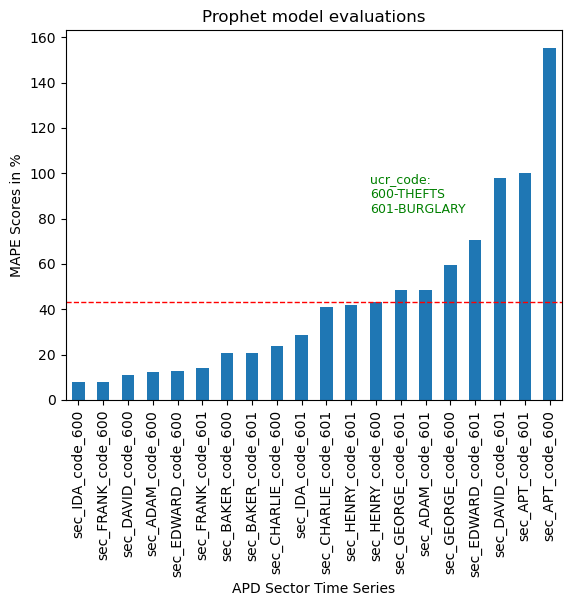

In [68]:
df_sorted = eval_results_df.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Prophet model evaluations")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')
text_pos_x = 0.60
text_pos_y = 0.50
plt.text(text_pos_x, text_pos_y, "ucr_code:\n600-THEFTS\n601-BURGLARY", fontsize=9,
transform=plt.gcf().transFigure, color='green')

APT sector shows high MAPE scores probably due to lack of data in that sector. Refer Cell# 26 There are no crimes recorded for APT sector. 

Prophet model predicted some good results for some sectors like IDA, ADAM, EDWARD, DAVID, FRANK for Theft crime as they are below 20% 